In [1]:
import os
import sys
from hydromt_sfincs import SfincsModel
import matplotlib.pyplot as plt

!hydromt --version

D:\repos\hydromt_sfincs\hydromt_sfincs\hydromt_sfincs\sfincs.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
D:\repos\hydromt\hydromt\io.py:14: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have t

hydroMT version: 0.6.1.dev


D:\repos\hydromt\hydromt\workflows\basin_mask.py:9: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
D:\repos\hydromt\hydromt\io.py:14: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the envir

Create grid from scratch

In [2]:
# Initialize SfincsModel with the artifact data catalog which contains data for North Italy
sf = SfincsModel(data_libs=["deltares_data"])


In [3]:
# set output location
sf.set_root("tmp_example")


Model dir already exists and files might be overwritten: d:\repos\hydromt_sfincs\hydromt_sfincs\examples\tmp_example\gis.


In [4]:
from hydromt.raster import RasterDataset
hasattr(RasterDataset, 'rotation')


True

<AxesSubplot:>

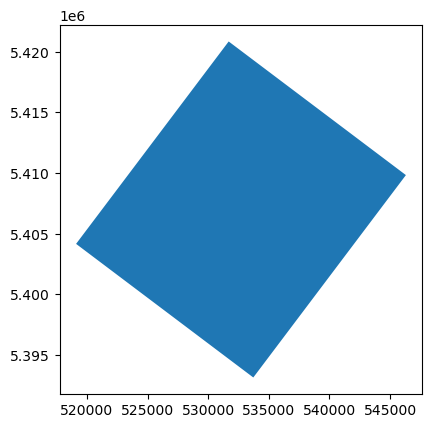

In [5]:
inp_dict = {
    "x0": 519106,
    "y0": 5404163,
    "dx": 100.0,
    "dy": 100.0,
    "nmax": 209,
    "mmax": 183,
    "rotation": -37.0148,
    "crs": 32610,  # crs: "WGS 84 / UTM zone 10N"
}
# create grid
sf.create_grid(grid_type="regular", **inp_dict)
# the input file is automatically updated
sf.region.plot()


Create mask purely based on include- and exclude polygons

In [6]:
from hydromt_sfincs import utils


In [7]:
#file_name = "sfincs_coastal//include.pol"
#gdf_include = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf.crs)

#file_name = "sfincs_coastal//exclude.pol"
#gdf_exclude = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf.crs)

#fig, ax = plt.subplots(1, 1)
#gdf_include.plot(ax=ax, color="green")
#gdf_exclude.plot(ax=ax, color="red")
#region = sf.reggrid.empty_mask.raster.box
#print(region)
#sf.set_geoms(region, "region")

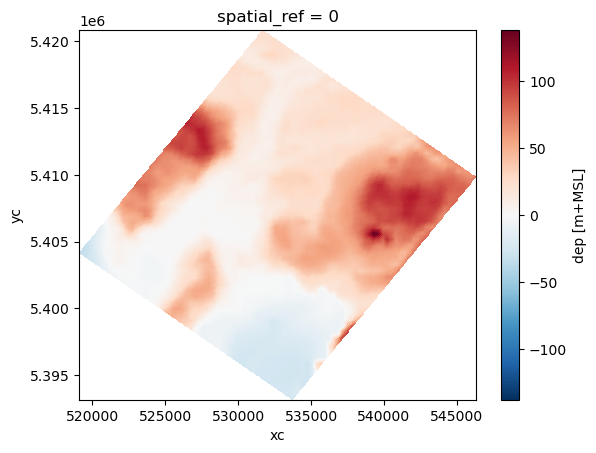

In [8]:
da_dep = sf.data_catalog.get_rasterdataset(
    "gebco", variables=["elevtn"], geom=sf.region, buffer=5
)

# List[dict]
# Provide merge arguments together with xr.DataAraay
da_dep_lst = [{"da":da_dep}]

# Add depth information to modelgrid
sf.create_dep(da_dep_lst=da_dep_lst)

sf.grid["dep"].plot(x='xc', y='yc')

0 gaps outside valid elevation range < 10 km2.


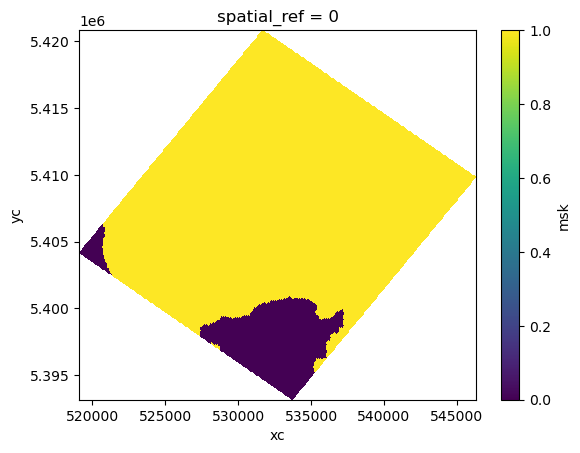

In [9]:


sf.create_mask_active(elv_min=-5, elv_max=500) #gdf_include=gdf_include, gdf_exclude=gdf_exclude)
sf.mask.plot(x='xc', y='yc')

Also take into account topobathy information

<AxesSubplot:>

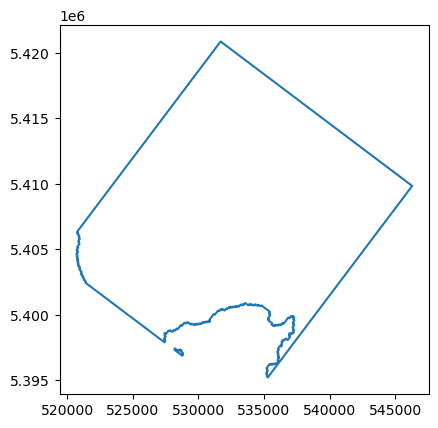

In [10]:
sf.region.boundary.plot()


In [11]:
#we would like to use the region to get raster data
#so reset region, otherwise region is only part of grid
#region = sf.reggrid.empty_mask.raster.box
#sf.set_geoms(region, "region")

In [12]:
# sf.grid.data.raster.set_crs(sf.grid.crs)


In [13]:
# Add depth information to modelgrid

0 gaps outside valid elevation range < 10 km2.
2 regions < 10 km2 dropped.


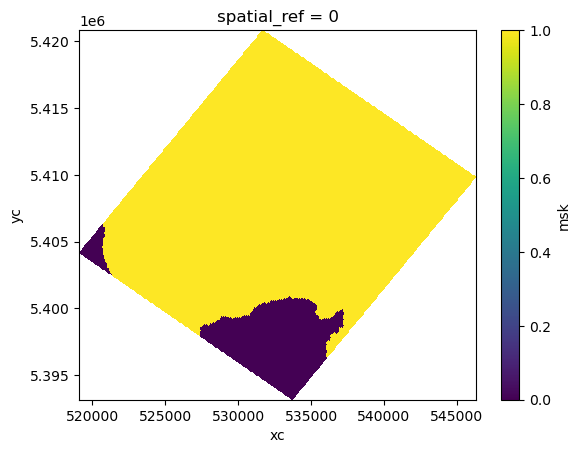

In [14]:
# play around with include, drop_area and fill_area
mask = sf.create_mask_active(
    elv_min=-5, elv_max=500, fill_area=10, drop_area=10, reset_mask=True
)
mask.plot(x='xc',y='yc')

In [15]:
#update mask; NOTE reset_mask=False by default
# mask = sf.create_mask_active(gdf_exclude=gdf_exclude)
# mask.plot.imshow()

Mask boundaries

In [16]:
file_name = "tmp_example\\bnd_wl.pol"
gdf_wl = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf.crs)

file_name = "tmp_example\\bnd_out.pol"
gdf_outflow = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf.crs)

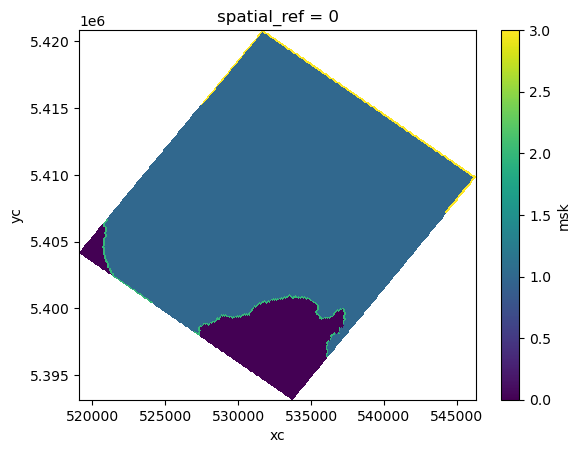

In [17]:
sf.create_mask_bounds(btype="waterlevel", gdf_include=gdf_wl, elv_max=0)
sf.create_mask_bounds(btype="outflow", gdf_include=gdf_outflow, elv_min=2)

sf.mask.plot(x='xc',y='yc')

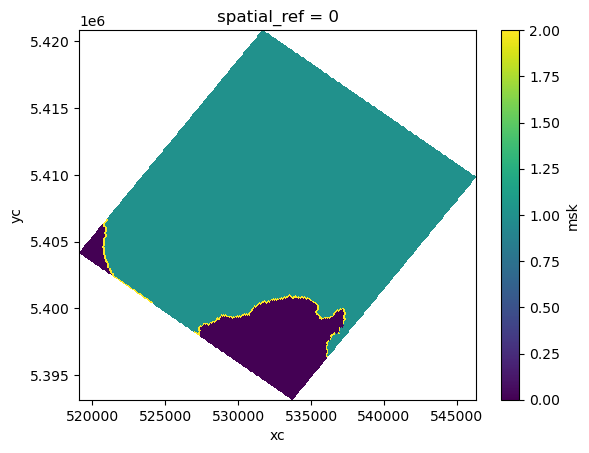

In [18]:
#reset outflow bounds
sf.create_mask_bounds(btype="outflow", reset_bounds=True)
sf.mask.plot(x='xc',y='yc')

#### subgrid

In [19]:
sf.create_subgrid(da_dep_lst=da_dep_lst, make_tiles = True)
#sf.create_subgrid(da_dep_lst=da_dep_lst, highres_dir='tmp_example\\tiles')

Number of regular cells in a block : 100
Number of blocks in n direction    : 3
Number of blocks in m direction    : 2
Grid size of flux grid            : dx=100.00000000014848, dy=99.99999999986886
Grid size of subgrid pixels       : dx=5.000000000007423, dy=4.9999999999934435

block 1/6 -- col 0:99 | row 0:99
Processing block with 9769 active cells ..

block 2/6 -- col 0:99 | row 100:199
Processing block with 10000 active cells ..

block 3/6 -- col 0:99 | row 200:208
Processing block with 900 active cells ..

block 4/6 -- col 100:182 | row 0:99
Processing block with 4360 active cells ..

block 5/6 -- col 100:182 | row 100:199
Processing block with 8300 active cells ..

block 6/6 -- col 100:182 | row 200:208
Processing block with 747 active cells ..


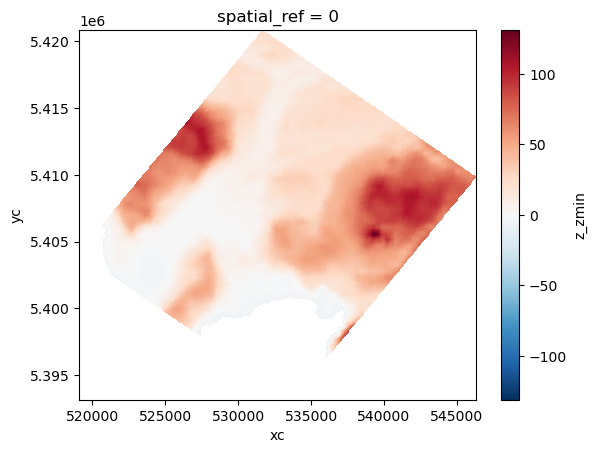

In [20]:
sf.subgrid["z_zmin"].plot(x='xc',y='yc')

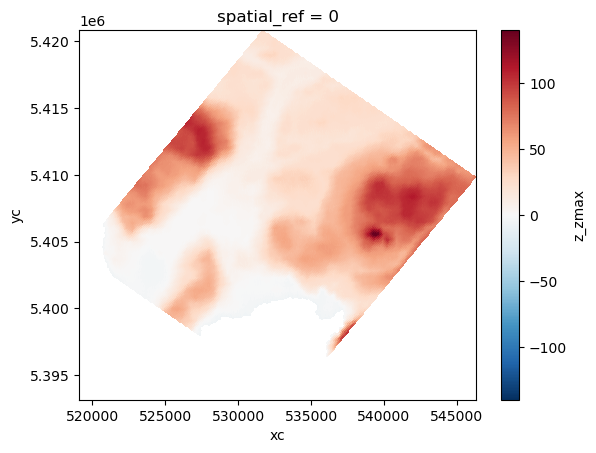

In [21]:
sf.subgrid["z_zmax"].plot(x='xc',y='yc')

### write

In [22]:
sf.set_root("tmp_example")

#sf.write_grid(data_vars=["dep"])  # write single grid map

In [ ]:
sf.write() #write all